In [4]:
import torch
import laplace
import matplotlib.pyplot as plt
import numpy as np


from batchbald_redux import repeated_mnist
from main.models import ConvNet, MLP
from main.training_models import train_model
from laplace.curvature import CurvlinopsGGN, BackPackGGN, AsdlGGN, BackPackEF, CurvlinopsEF, AsdlEF

%reload_ext autoreload
%autoreload 2

In [36]:
# load mnist data
train_dataset, val_dataset = repeated_mnist.create_MNIST_dataset()

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32,
                                           sampler=torch.utils.data.SubsetRandomSampler(range(1000)))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(range(1000)))

x_test, y_test = next(iter(val_loader))
#x_pool = torch.cat([data[0] for data in val_loader])
#y_pool = torch.cat([data[1] for data in val_loader])

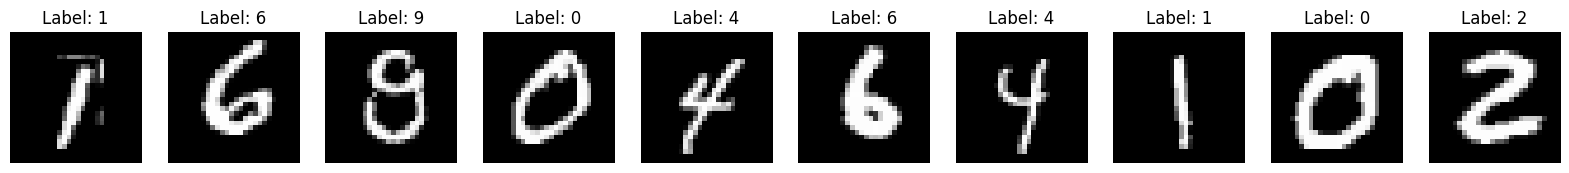

In [6]:
# plot random subset of images in training set
fig, ax = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # generate random index in training set
    idx = np.random.randint(0, len(train_loader.sampler))

    ax[i].imshow(train_dataset[idx][0].squeeze(), cmap='gray')
    ax[i].axis('off')
    ax[i].title.set_text('Label: {}'.format(train_dataset[idx][1]))

In [7]:
model = ConvNet()
model = train_model(model, train_loader, num_epochs=50, lr=1e-3, reg_lambda=0)

# evaluate model on validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 1000 test images: {}'.format(correct/total))

Epoch 1/50, Loss: 2.277506113052368
Epoch 6/50, Loss: 0.9361218214035034
Epoch 11/50, Loss: 0.4301944375038147
Epoch 16/50, Loss: 0.009570385329425335
Epoch 21/50, Loss: 0.048046331852674484
Epoch 26/50, Loss: 0.015718448907136917
Epoch 31/50, Loss: 0.0150437718257308
Epoch 36/50, Loss: 0.0006548514356836677
Epoch 41/50, Loss: 0.007705794181674719
Epoch 46/50, Loss: 0.001425927272066474
Accuracy of the network on the 1000 test images: 0.695


In [37]:
la = laplace.Laplace(model, likelihood='classification', subset_of_weights='last_layer',
                     hessian_structure='kron', backend = AsdlGGN, prior_precision=1)
la.fit(train_loader)
la.optimize_prior_precision(method='marglik', verbose = True, pred_type='glm', n_steps=1000)

Optimized prior precision is tensor([12.1777]).


In [38]:
# check accuracy of model with laplace approximation
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = la(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy of the network on the 1000 test images: {}'.format(correct/total))


Accuracy of the network on the 1000 test images: 0.693


### Testing Jacobians to compute EIG directly

In [10]:
Js, f_mu = la.backend.jacobians(x_test, enable_backprop=True)  # (batch, num_classes, num_parameters)
Js.count_nonzero() / Js.numel()

c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ..\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


tensor(0.9452)

## Check correctness precision and Hessian

In [11]:
from main.approximation import H_p

In [39]:
P = la.posterior_precision.to_matrix() # (num_parameters, num_parameters)
H = la.H.to_matrix()
hp = H_p(la, x_test)  # (batch, num_classes, num_parameters)

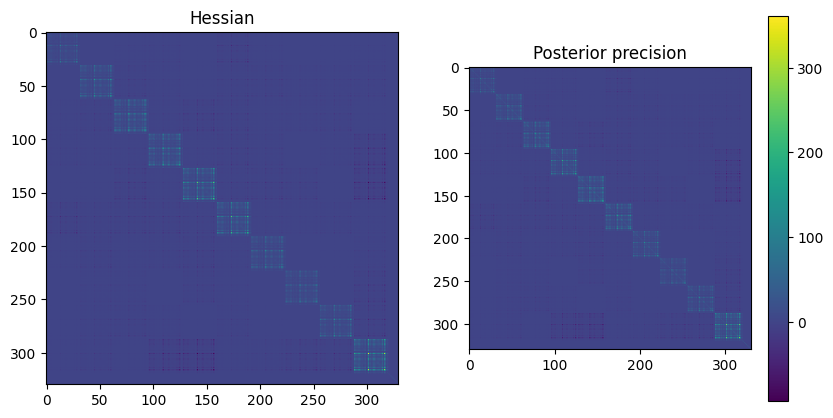

In [40]:
# plot hessian and P side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(H)
ax[0].set_title('Hessian')

ax[1].imshow(P)
ax[1].set_title('Posterior precision')

# set same color scale for both plots
vmin = min(H.min(), P.min())
vmax = max(H.max(), P.max())
ax[0].imshow(H, vmin=vmin, vmax=vmax)
ax[1].imshow(P, vmin=vmin, vmax=vmax)
plt.colorbar(ax[1].imshow(P, vmin=vmin, vmax=vmax))
plt.show()

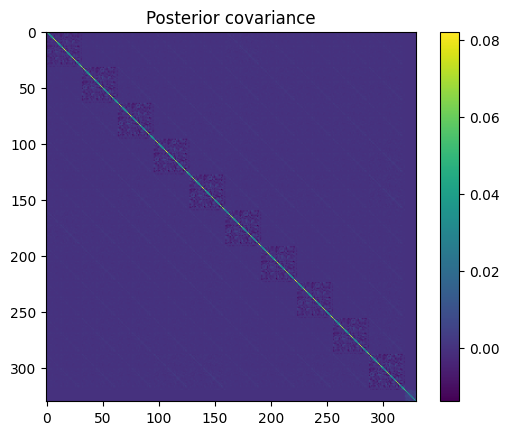

In [41]:
# plot posterior covariance
P_inv = torch.inverse(P)

plt.imshow(P_inv)
plt.colorbar()
plt.title('Posterior covariance')
plt.show()

In [42]:
print(f'determinant of the hessian: {H.det()}')
print(f'determinant of the posterior precision: {P.det()}')

determinant of the hessian: 0.0
determinant of the posterior precision: inf


### Computing similarity matrix


In [43]:
pseudo_label = la(x_test).argmax(dim=1)  # (batch)
# apply predicted as mask
hp_hat = hp[torch.arange(hp.shape[0]), pseudo_label].view(hp.shape[0], -1)  # (batch, num_parameters)

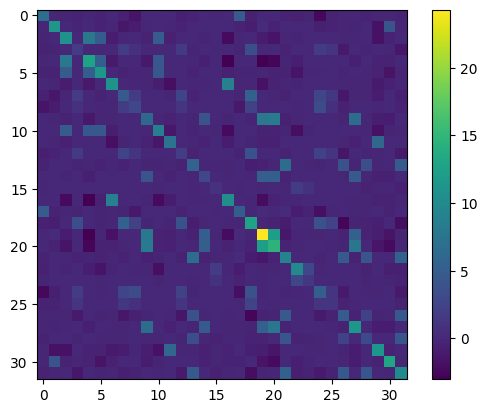

In [44]:
S = hp_hat @ P.inverse() @ hp_hat.T
plt.imshow(S.detach())
plt.colorbar()
S.trace()

S_pseudo = S

### Comparing sampling vs pseudolabels

Text(0.5, 1.0, 'Pseudo')

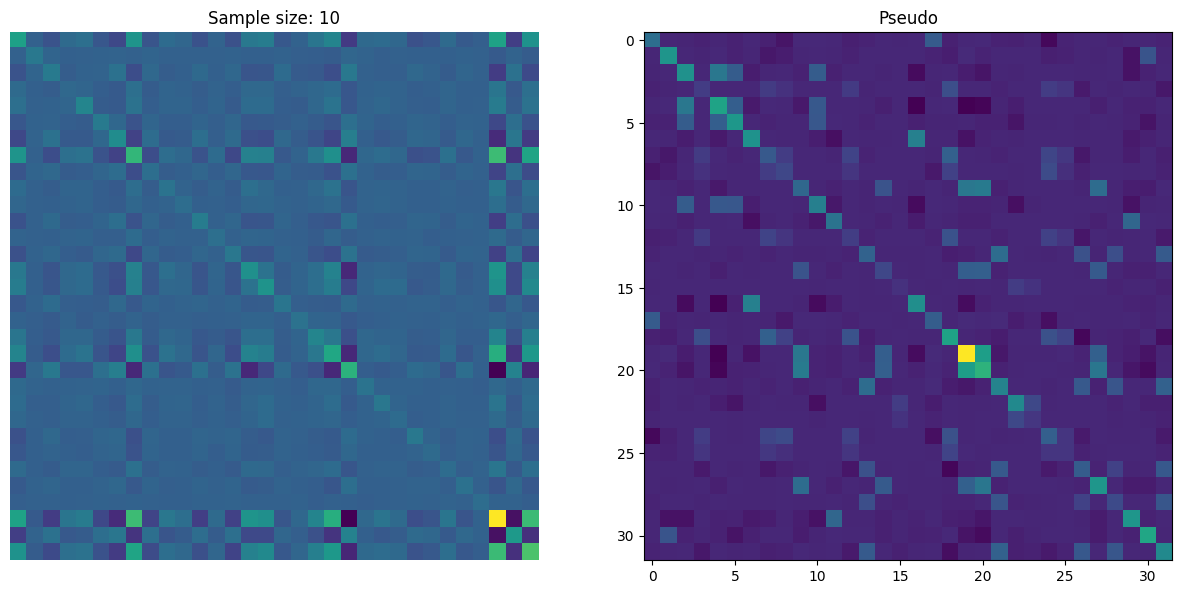

In [62]:
# num plots
k = 1

fig, ax = plt.subplots(1, k + 1, figsize=(15, 10))

for i, b in enumerate(10 ** np.arange(1, k + 1)):
    hp_hat = sample_hp_hat(la, x_test)
    S = hp_hat @ P.inverse() @ hp_hat.T
    ax[i].imshow(S.detach())
    ax[i].set_title(f'Sample size: {b}')
    ax[i].axis('off')


ax[-1].imshow(S_pseudo.detach())
ax[-1].set_title('Pseudo')

## Comparing S and BALD score computation

In [ ]:
import scipy as sp
from main.bald_sampling import set_last_linear_layer_combined

In [ ]:
def compute_bald(probs_K_N_C):
    entropy_K_N = compute_entropy(probs_K_N_C)
    entropy_N = entropy_K_N.mean(dim=0)
    avg_probs_N_C = probs_K_N_C.mean(dim=0)
    avg_entropy_N = compute_entropy(avg_probs_N_C)
    score = avg_entropy_N - entropy_N
    return score

def compute_entropy(probs_C):
    nats = -probs_C * probs_C.log()
    nats = torch.where(nats.isnan(), 0.0, nats)
    entropy = nats.sum(dim=-1)
    return entropy

def compute_probs(la_model, x, train_loader, K=10, refit=False):
    N, C = x.shape[0], 10
    posterior_weights = la_model.sample(K)
    probs = torch.zeros(K, N, C)
    for i, weights in enumerate(posterior_weights):
        print(f'Computing probs for sample {i} out of {K}')
        # Set the weights in the model
        if la_model.backend.last_layer:
            with torch.no_grad():   
                set_last_linear_layer_combined(la_model.model, weights)

        if refit:
            # fit the model
            la_model.fit(train_loader)

            # Optimise the prior precision
            la_model.optimize_prior_precision(pred_type='glm', method='marglik', link_approx='probit', verbose=False)

        # Compute the predictive distribution
        p  = la_model(x, pred_type='glm', link_approx='probit')
        probs[i] = p
    
    return probs

In [ ]:
probs = compute_probs(la, x_test, refit=False, train_loader=train_loader, K=100)
bald = compute_bald(probs)

Computing probs for sample 0 out of 100
Computing probs for sample 1 out of 100
Computing probs for sample 2 out of 100
Computing probs for sample 3 out of 100
Computing probs for sample 4 out of 100
Computing probs for sample 5 out of 100
Computing probs for sample 6 out of 100
Computing probs for sample 7 out of 100
Computing probs for sample 8 out of 100
Computing probs for sample 9 out of 100
Computing probs for sample 10 out of 100
Computing probs for sample 11 out of 100
Computing probs for sample 12 out of 100
Computing probs for sample 13 out of 100
Computing probs for sample 14 out of 100
Computing probs for sample 15 out of 100
Computing probs for sample 16 out of 100
Computing probs for sample 17 out of 100
Computing probs for sample 18 out of 100
Computing probs for sample 19 out of 100
Computing probs for sample 20 out of 100
Computing probs for sample 21 out of 100
Computing probs for sample 22 out of 100
Computing probs for sample 23 out of 100
Computing probs for sample

In [ ]:
import gpytorch as gpt